In [ ]:
# TASK
# You are being provided data about the items we receive in our warehouses. 
# Your task is to make a model that predicts how long it will take for each item to be purchased. 
# The time it takes for an item to sell is simply the difference between the listed_at and purchased_at dates. 
# You may use any type of model(s) you’d like to accomplish this task. 
# Note: items that do not have a purchased_at date had not been purchased as of the date of this data pull, which was 2/20/2017. 

In [ ]:
# MY SUMMARY IS AT THE END OF NOOTBOOK

In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import re
import numpy as np
import pandas as pd
import csv
import pandas_profiling as pp
import calmap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
import xgbfir

from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report
from sklearn import metrics

from category_encoders import BackwardDifferenceEncoder, LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit,train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter('ignore')
%pylab inline

pd.options.display.max_rows = 86
pd.options.display.max_columns = 27

Populating the interactive namespace from numpy and matplotlib


# Loading Data

In [575]:
data = pd.read_csv("items.csv",error_bad_lines=False,warn_bad_lines=False)
data.head()

,item_number,brand_id,brand_name,brand_tier_id,category_id,category_name,category_tier_id,itemization_category_group_id,sizing_id,size_tier_id,size_label,new_with_tags,quality_code,quality_reason_codes,merchandising_department,primary_material,secondary_material,original_msrp,original_price,payout_policy,seasonal_slope_30d,relisted,warehouse_id,listed_at,purchased_at
0,20042271,32737,Lucie Lu,6.0,346.0,Casual Dress,10,42.0,858.0,24.0,2X,0.0,Q2,Needs washing,plus,Polyester,Spandex,7100.0,1699.0,upfront,0.004244,0.0,4.0,2017-02-19 16:40:09,NaN
1,20028301,36671,Isabel + Alice,7.0,346.0,Casual Dress,10,42.0,844.0,24.0,1X,0.0,Q1,NaN,plus,Polyester,Spandex,11900.0,2699.0,upfront,0.004244,0.0,3.0,2017-02-19 14:22:42,NaN
2,22612071,2804,Free People,7.0,743.0,Short Sleeve Blouse,9,39.0,778.0,24.0,Sm,0.0,Q1,NaN,X,Cotton,Nylon,9800.0,2299.0,upfront,0.005165,1.0,1.0,2017-02-19 14:01:55,2017-02-19 17:25:19
3,22612052,982,Banana Republic,7.0,329.0,Pullover Sweater,10,40.0,812.0,24.0,Lg,0.0,Q1,NaN,women,Polyester,Metallic,7800.0,2599.0,upfront,-0.006519,1.0,3.0,2017-02-19 14:01:54,NaN
4,22612043,128,Gap,4.0,356.0,Jeans,10,77.0,806.0,24.0,30,0.0,Q1,NaN,women,Cotton,Polyester,7000.0,1699.0,upfront,-0.000691,1.0,3.0,2017-02-19 14:01:53,NaN


In [3]:
%%time
# Some rows have more or less then 25 columns 
# I need to split columns 2 and 3 that contains separated brand namee

too_big_objects = []
too_small_objects = []

with open("C:/Users/lyaba/test_task/items.csv") as my_file:
    reader = csv.reader(my_file, delimiter=',')
    for row in reader:
        if len(row)<25:
            too_small_objects.append(row)
        elif len(row)>25:
            too_big_objects.append(row)

            
too_big_objects_df = pd.DataFrame(too_big_objects)   
too_big_objects_df[2] = too_big_objects_df[2] + too_big_objects_df[3]
too_big_objects_df = too_big_objects_df.drop([3],axis=1)


Wall time: 1.62 s


In [4]:
column_names = data.columns
too_big_objects_df.columns = column_names
too_big_objects_df.head()

,item_number,brand_id,brand_name,brand_tier_id,category_id,category_name,category_tier_id,itemization_category_group_id,sizing_id,size_tier_id,size_label,new_with_tags,quality_code,quality_reason_codes,merchandising_department,primary_material,secondary_material,original_msrp,original_price,payout_policy,seasonal_slope_30d,relisted,warehouse_id,listed_at,purchased_at
0,22418511,36337,Love Hanna,20,346,Casual Dress,10,42,812,24,Lg,0,Q2,Minor stain,women,Cotton,Modal,9500,2499,consignment,0.004236227278077315,1,1,2017-02-15 10:03:42,2017-02-17 05:11:05
1,22418033,14183,Pursuits Ltd.,18,348,Casual Skirt,9,69,822,24,12,0,Q1,,women,Polyester,Rayon,2200,499,upfront,0.0008998585131605179,0,4,2017-02-15 00:02:04,2017-02-16 04:43:00
2,22316151,8681,Love Fire,4,346,Casual Dress,10,42,795,24,Med,1,Q2,Pre pilling,juniors,Polyester,,4800,1499,upfront,0.0042595703682310904,0,5,2017-02-14 02:00:27,2017-02-15 15:59:06
3,22421421,28995,Love Carmen,3,346,Casual Dress,10,42,822,24,12,1,Q1,,women,Polyester,,3600,1299,upfront,0.004290993488879913,1,5,2017-02-13 19:03:43,2017-02-19 03:21:31
4,22350333,8681,Love Fire,4,346,Casual Dress,10,42,812,24,Lg,0,Q2,Minor snag,juniors,Polyester,,4800,1299,upfront,0.004373933094044356,0,5,2017-02-11 03:01:27,


So now we have a DataFrame of 85 objects

# Preprocessing data

In [5]:
# Preprocess 85 columns that we couldn't download with pandas

too_big_objects_df = too_big_objects_df.replace('', np.nan) 

to_numeric_cols = sorted([
    'item_number',
    'brand_id', 
    'category_tier_id',
    "brand_tier_id",
    'category_id',
    'itemization_category_group_id',
    'sizing_id', 
    'original_msrp', 
    'original_price', 
    'seasonal_slope_30d',
    'warehouse_id',
    'new_with_tags',
    'relisted',
    'size_tier_id'
])

for i in to_numeric_cols:
    too_big_objects_df[i] = pd.to_numeric(too_big_objects_df[i], downcast="integer", errors="coerce")


In [6]:
# Concat two datasets

data_df = pd.concat([data,too_big_objects_df],ignore_index=True)

In [16]:
pp.ProfileReport(data_df)

Number of variables,25
Number of observations,471253
Total Missing (%),6.2%
Total size in memory,89.9 MiB
Average record size in memory,200.0 B
Numeric,10
Categorical,13
Boolean,0
Date,0
Text (Unique),1
Rejected,1


In [18]:
# item_number has all unique values it's index
# look at merchandising_department
# Look at new_with_tags
# look at payout_policy
# look at quality_code
# Look at relisted
# Look at size_tier_id


In [7]:
to_numeric_cols = sorted([
    'item_number',
    'brand_id', 
    'category_tier_id'
])

#-------------------------------------------------------
numeric_cols = sorted([
    "brand_tier_id",
    'category_id',
    'itemization_category_group_id',
    'sizing_id', 
    'original_msrp', 
    'original_price', 
    'seasonal_slope_30d',
    'warehouse_id'])

#-------------------------------------------------------
ordinal_cols = sorted([
    'quality_code'
])

#-------------------------------------------------------
binary_cols = [
    'new_with_tags',
    'relisted',
    'size_tier_id',
    'payout_policy'
]

#-------------------------------------------------------
categorical_cols = sorted([
    'brand_name', 
    'category_name', 
    'size_label', 
    'quality_reason_codes', 
    'merchandising_department', 
    'primary_material', 
    'secondary_material',
    'listed_at',
    'purchased_at'
])

#-------------------------------------------------------
#date_cols = [
    #'listed_at',
    #'purchased_at']
    
# ---------------------------------------------------------------
print('to numeric: {}\nnumeric: {}\ncategorical: {}\nordinal: {}\nbinary: {}'.format(
    len(to_numeric_cols),len(numeric_cols), len(categorical_cols), len(ordinal_cols), len(binary_cols)))

to numeric: 3
numeric: 8
categorical: 9
ordinal: 1
binary: 4


In [8]:
# convert features with type object to int

for i in to_numeric_cols:
    data_df[i] = pd.to_numeric(data_df[i], downcast="integer", errors="coerce")

In [9]:
# drop rows wits NaN's in numeric_cols

data_df = data_df.dropna(subset=to_numeric_cols)
data_df = data_df.dropna(subset=['listed_at'])

In [12]:
data_df.item_number.isna().any()

False

In [13]:
data_df.payout_policy.value_counts()

upfront        391600
consignment     79650
Name: payout_policy, dtype: int64

In [14]:
data_df.quality_code.value_counts()

Q1    270818
Q2    189626
Q3     10806
Name: quality_code, dtype: int64

In [15]:
# now size_tier_id is constant value

data_df = data_df.drop('size_tier_id',axis=1)

# Little work on cat data

In [16]:
# caigorical features to lower case
data_df[categorical_cols] = data_df[categorical_cols].apply(lambda x: x.str.lower())

# fill NaN with "no info"
categorical_cols_nan = ['primary_material', 'quality_reason_codes', 'secondary_material']
data_df[categorical_cols_nan] = data_df[categorical_cols_nan].fillna("no info")

# A little transfor for size data
data_df.size_label = data_df.size_label.replace({'m':'med','s':'sm'})

In [28]:
pp.ProfileReport(data_df)

Number of variables,25
Number of observations,471250
Total Missing (%),1.3%
Total size in memory,89.9 MiB
Average record size in memory,200.0 B
Numeric,11
Categorical,11
Boolean,2
Date,0
Text (Unique),0
Rejected,1


In [17]:
# I need to process seasonal_slope_30d NaNs, but for now fill nan with -1

data_df.seasonal_slope_30d.fillna(-1,inplace=True)

In [18]:
# Binary columns preprocessing

data_df[binary_cols[:2]] = data_df[binary_cols[:2]].astype(int)
data_df['payout_policy'] = data_df['payout_policy'].apply(lambda x: 1 if x=='upfront' else 0)
data_df.payout_policy.value_counts()

1    391600
0     79650
Name: payout_policy, dtype: int64

# Feature engineering

In [19]:
# Encoding ordinal data

encoder = BackwardDifferenceEncoder(cols=ordinal_cols)
data_df_ec= encoder.fit_transform(data_df)

new_cols = ['quality_code_0','quality_code_1','quality_code_2']
data_df[['quality_code_0','quality_code_1','quality_code_2']] = data_df_ec[['col_quality_code_0','col_quality_code_1','col_quality_code_2']]
data_df.drop('quality_code',axis=1,inplace=True)

In [20]:
# Convert string into DateTime

data_df.listed_at = data_df.listed_at.apply(pd.to_datetime)
data_df.purchased_at = data_df.purchased_at.apply(pd.to_datetime)

In [21]:
# Create two new features

data_df['weekday'] = data_df['listed_at'].apply(lambda x: x.date().weekday())
data_df['is_weekend'] = data_df['listed_at'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)

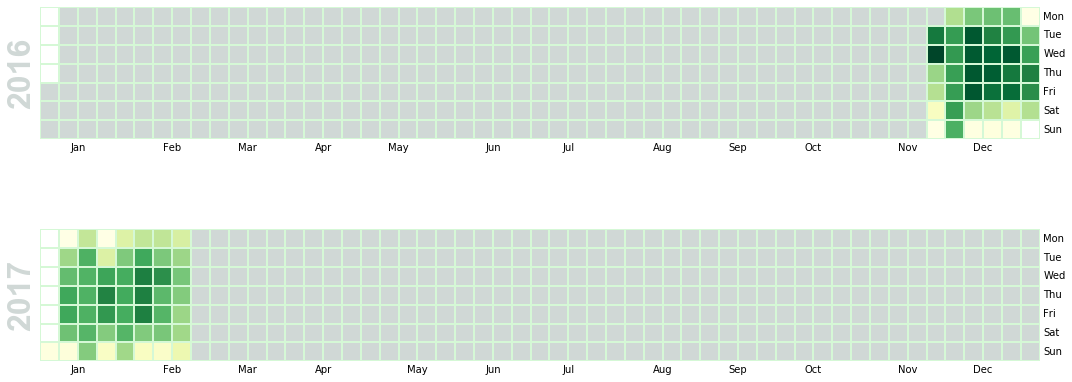

In [22]:
# Heatmap of listed products

listed_at_data = data_df.listed_at.value_counts()
purchased_at = data_df.purchased_at.value_counts()

fig, ax = calmap.calendarplot(listed_at_data, fig_kws={"figsize":(15,7)}, fillcolor='#d0d8d6', cmap='YlGn',linecolor='#d5f8d6')


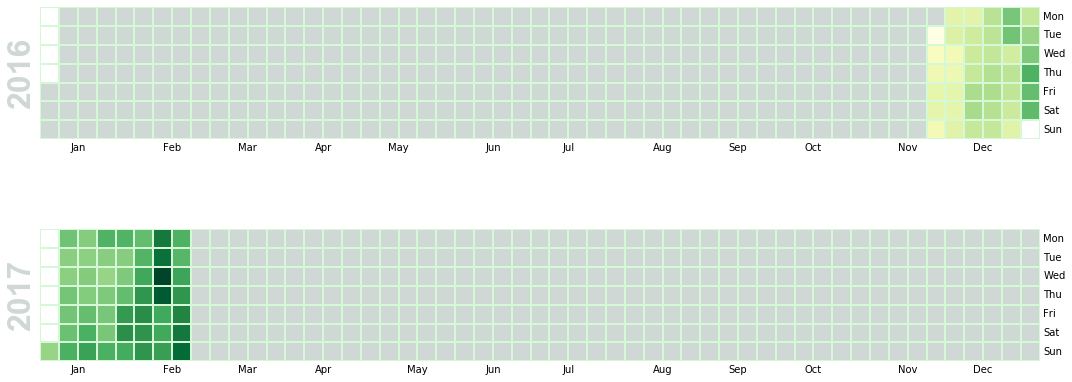

In [23]:
# Heatmap of purchased products

fig, ax = calmap.calendarplot(purchased_at, fig_kws={"figsize":(15,7)}, fillcolor='#d0d8d6', cmap='YlGn',linecolor='#d5f8d6')


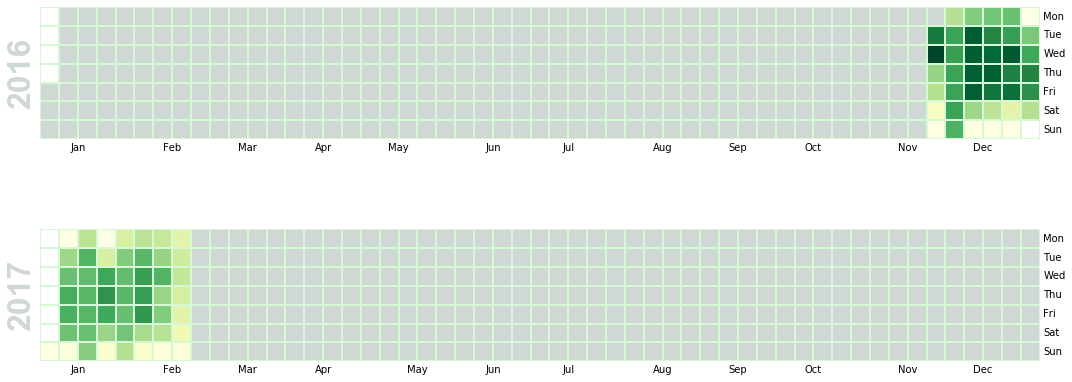

In [24]:
# Visualisation of date with listed and purchased products 

listed_and_purchased = data_df[~data_df.purchased_at.isna()].listed_at.value_counts()
fig, ax = calmap.calendarplot(listed_and_purchased, fig_kws={"figsize":(15,7)}, fillcolor='#d0d8d6', cmap='YlGn',linecolor='#d5f8d6')


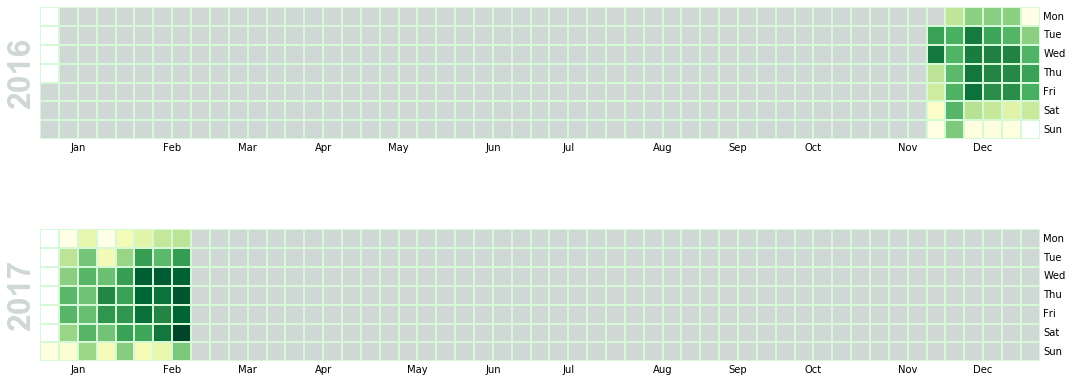

In [25]:
# Visualisation of date with listed and not purchased products 

listed_not_purchased = data_df[data_df.purchased_at.isna()].listed_at.value_counts()
fig, ax = calmap.calendarplot(listed_not_purchased, fig_kws={"figsize":(15,7)}, fillcolor='#d0d8d6', cmap='YlGn',linecolor='#d5f8d6')


In [26]:
listed_not_purchased = pd.DataFrame(listed_not_purchased)
listed_not_purchased.reset_index(inplace=True)
listed_not_purchased['after_december'] = listed_not_purchased['index'].apply(lambda x: 1 if (x>=pd.to_datetime('2017-01-01')) else 0)

listed_not_purchased.after_december.value_counts()

1    52085
0    39208
Name: after_december, dtype: int64

In [27]:
listed_and_purchased = pd.DataFrame(listed_and_purchased).reset_index()
listed_and_purchased['after_december'] = listed_and_purchased['index'].apply(lambda x: 1 if (x>=pd.to_datetime('2017-01-01')) else 0)

listed_and_purchased.after_december.value_counts()

1    70606
0    64542
Name: after_december, dtype: int64

In [25]:
listed_and_purchased[listed_and_purchased.after_december == False].listed_at.sum() /((listed_and_purchased[listed_and_purchased.after_december == True].listed_at.sum())+listed_and_purchased[listed_and_purchased.after_december == False].listed_at.sum())

0.5324940405244338

In [26]:
listed_not_purchased[listed_not_purchased.after_december == True].listed_at.sum() /((listed_not_purchased[listed_not_purchased.after_december == True].listed_at.sum())+listed_not_purchased[listed_not_purchased.after_december == False].listed_at.sum())

0.5699741983044601

In [76]:
# Hypothesis correct
# 53% purchased products were listed before new year
# 57% not purchased products were listed bfore new year

In [28]:
# Ad new feature month

data_df['month'] = data_df['listed_at'].apply(lambda x: x.date().month)

In [29]:
# Target for classification

data_df['is_purchased'] = 1
data_df.loc[data_df.purchased_at.isnull(), 'is_purchased'] = 0

## Label encoding

In [30]:
data_df_le = data_df.copy()

In [31]:
categorical_cols = sorted([
    'brand_name', 
    'category_name', 
    'size_label', 
    'quality_reason_codes', 
    'merchandising_department', 
    'primary_material', 
    'secondary_material'
])

In [33]:
# label encoding of categorical features

for i in categorical_cols:
    #print("Start encode {}".format(i))
    le = LabelEncoder()
    data_df_le[i] = le.fit_transform(data_df_le[i])
    #print(i)

In [34]:
# item_number is just an id of single product

data_df.drop(['item_number'],axis=1,inplace=True)

## Leave One Out encoding

In [185]:
# data_df.index = np.arange(0,len(data_df))

In [186]:
# train/test split for leave one out encodet df

X_train_leo, X_test_leo, y_train_leo, y_test_leo = train_test_split(data_df,data_df.is_purchased,test_size=0.3,random_state = 42, shuffle=True,stratify=data_df.is_purchased)

In [164]:
def get_time():
    return datetime.datetime.time(datetime.datetime.now())

In [184]:
%%time

# Leave One Out encoding of categorical features

data_df_looe = data_df.copy()
for i in categorical_cols:
    looe = LeaveOneOutEncoder()
    #print("Encoding of {} feature starts at {}".format(i,get_time()))
    new_df = pd.concat([X_train_leo,X_test_leo])
    looe.fit(X_train_leo[[i]],y_train_leo)
    data_df_looe[i] = looe.transform(new_df[[i]])

In [97]:
data_df_looe.to_csv('data_df_looe_2.csv',index=True)

In [187]:
data_df_looe = pd.read_csv('data_df_looe_2.csv', index_col=0)

In [169]:
#data_df_looe.index = np.arange(0,len(data_df_looe))

# Label encoding VS Leave One Out encoding

In [188]:
# Create Random forrest classifier

rfc = RandomForestClassifier(n_estimators=10, max_depth=10,random_state=42)

In [189]:
data_df_le[to_numeric_cols]=data_df_le[to_numeric_cols].astype(int)
data_df_looe[to_numeric_cols[:-1]]=data_df_looe[to_numeric_cols[:-1]].astype(int)

In [190]:
#list_index = new_df.index.tolist()

In [191]:
# Validation strategy

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)

In [192]:
# Label encoded data for classificationData for 

X_le = data_df_le.drop(['listed_at', 'purchased_at', 'is_purchased'], axis=1)
y_le = data_df_le.is_purchased

In [193]:
# train/test split for lebel encodet df

X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(X_le,y_le,test_size=0.3,random_state = 42, shuffle=True,stratify=y_le)

In [878]:
# LOO encoded data for classification

X_train_looe = data_df_looe.loc[X_train_leo.index].drop(['listed_at', 'purchased_at', 'is_purchased'], axis=1)
y_train_looe = data_df_looe.loc[X_train_leo.index].is_purchased
X_test_looe = data_df_looe.loc[X_test_leo.index].drop(['listed_at', 'purchased_at', 'is_purchased'], axis=1)
y_test_looe = data_df_looe.loc[X_test_leo.index].is_purchased

In [884]:
#X_train_looe.drop(['days_before_purchase'],axis=1,inplace=True)
#_test_looe.drop(['days_before_purchase'],axis=1,inplace=True)

In [885]:
# Ecperiment. Labal encoding vS Leave One Out encoding

scores_rfc_le = cross_val_score(
    estimator=rfc,
    X= X_train_le, # ...
    y= y_train_le, # ...
    scoring='roc_auc', # ...
    cv=sss, # cross-validation strategy
    n_jobs=-1
).mean()
print('RFC LabelEncoder scoring: {:.2f}'.format(scores_rfc_le))

scores_rfc_leo = cross_val_score(
    estimator=rfc,
    X= X_train_looe, # ...
    y= y_train_looe, # ...
    scoring='roc_auc', # ...
    cv=sss, # cross-validation strategy
    n_jobs=-1
).mean()
print('RFC LeaveOneOutEncoder scoring: {}'.format(scores_rfc_leo))

RFC LabelEncoder scoring: 0.78
RFC LeaveOneOutEncoder scoring: 0.8122262750970238


# Other CV strategy

# Time validation

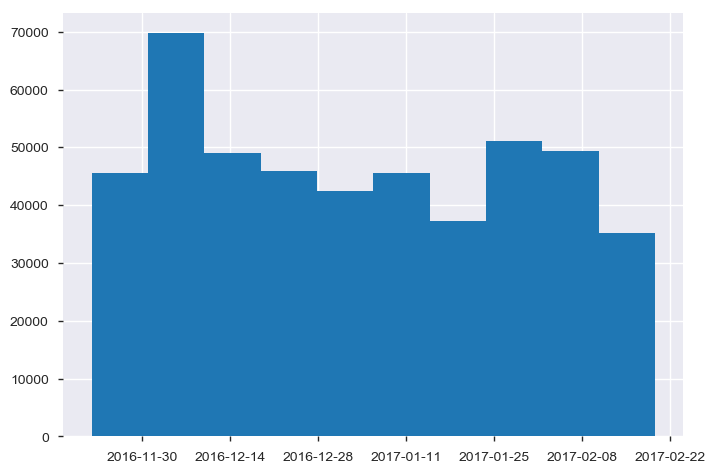

In [135]:
data_df.listed_at.hist()

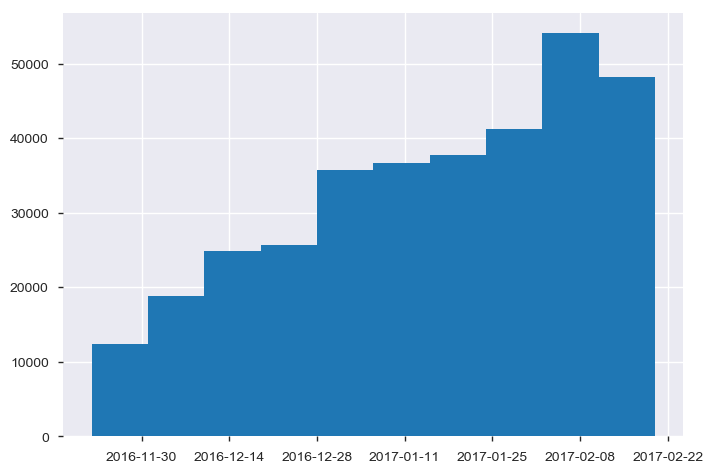

In [136]:
data_df.purchased_at.hist()

In [200]:
# Create data for time validation

time_val_data = data_df.copy()
time_val_data.listed_at = data_df.listed_at.apply(lambda x: x.replace(hour = 0,minute = 0, second = 0))

In [203]:
# Find first train, validation and test days

test_start = time_val_data.listed_at.max() - relativedelta(days=19)
val_start = test_start - relativedelta(days=19)
train_start = time_val_data.listed_at.min()

In [204]:
# Holdout time validation

def train_test_split_h(df, feature_name, test_lengh):
    
    test_start = time_val_data.listed_at.max() - relativedelta(days=test_lengh)
    train_start = test_start
    #validation = df.loc[(df.Date >= train_end_date)]
    train = df[df[feature_name] <= test_start]
    test = df[df[feature_name] > test_start]
    return train, test

In [205]:
train, test = train_test_split_h(time_val_data, 'listed_at', 19)

train_tm = train.listed_at.value_counts()*0 +20
test_tm = test.listed_at.value_counts()*0 +25
all_data = pd.concat([train_tm, test_tm])

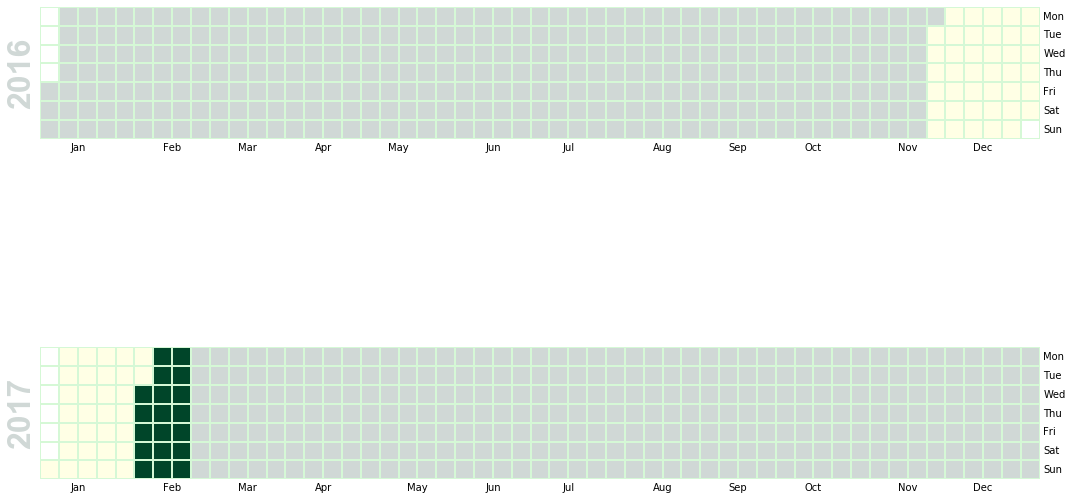

In [206]:
fig, ax = calmap.calendarplot(all_data, fig_kws={"figsize":(15,12)}, fillcolor='#d0d8d6', cmap='YlGn',linecolor='#d5f8d6')


In [240]:
%%time

time_val_data_looe = time_val_data.copy()
for i in categorical_cols:
    looe = LeaveOneOutEncoder()
    new_time_val_df = pd.concat([train,test])
    looe.fit(train[[i]],train.is_purchased)
    time_val_data_looe[i] = looe.transform(new_time_val_df[[i]])

In [656]:
#time_val_data_looe.to_csv('time_val_data_looe_2.csv',index=True)

In [208]:
#time_val_data_looe = pd.read_csv("time_val_data_looe.csv",index_col=0)

In [251]:
#X_train.listed_at = X_train.listed_at.apply(lambda x: pd.to_datetime(x))
#X_test.listed_at = X_test.listed_at.apply(lambda x: pd.to_datetime(x))

In [250]:
X_train = time_val_data_looe.loc[train.index].drop(['purchased_at', 'is_purchased'], axis=1)
y_train = time_val_data_looe.loc[train.index].is_purchased
X_test = time_val_data_looe.loc[test.index].drop(['purchased_at', 'is_purchased'], axis=1)
y_test = time_val_data_looe.loc[test.index].is_purchased

In [214]:
scores_rfc_loe = cross_val_score(
    estimator=rfc,
    X= X_train.drop(['listed_at'],axis=1), 
    y= y_train, 
    scoring='roc_auc', # ...
    cv=sss, # cross-validation strategy
    n_jobs=-1
).mean()
print('RFC LeaveOneOutEncoder scoring: {}'.format(scores_rfc_leo))

RFC LeaveOneOutEncoder scoring: 0.8122262750970238


In [253]:
# K-fold time validation

dates_validation = ['2016-12-24', '2017-01-12']
dates_train = ['2016-11-22','2016-12-11']

def create_validation(df, featur_name, train_start_date, validation_start_date, validation_size):
    """
    Split sample to train and validaton
    by days
    """
    return df.loc[(df[featur_name] >= pd.to_datetime(train_start_date)) & \
                  (df[featur_name] <=  pd.to_datetime(validation_start_date))].index, \
           df.loc[(df[featur_name] > pd.to_datetime(validation_start_date)) & \
                  (df[featur_name] <=  pd.to_datetime(validation_start_date) + relativedelta(days = validation_size))].index,\

In [254]:
myCViterator = []
for i,j in zip(dates_train, dates_validation):
    trainIndices, valIndices= create_validation(X_train.reset_index().drop('index',axis=1), 'listed_at', i, j, 19)
    trainIndices, valIndices= create_validation(X_train.reset_index().drop('index',axis=1), 'listed_at', i, j, 19)
    myCViterator.append( (trainIndices, valIndices) )

In [261]:
for i,j in myCViterator:
    print (min(i), min(j))

174912 93251
93251 0


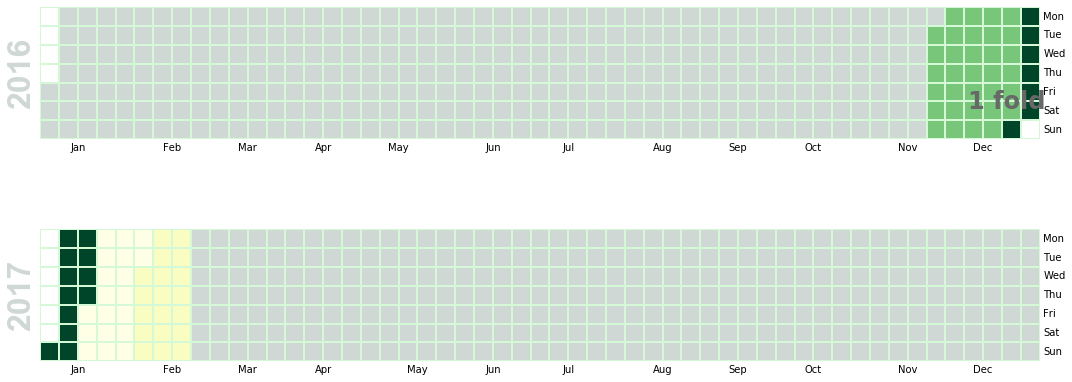

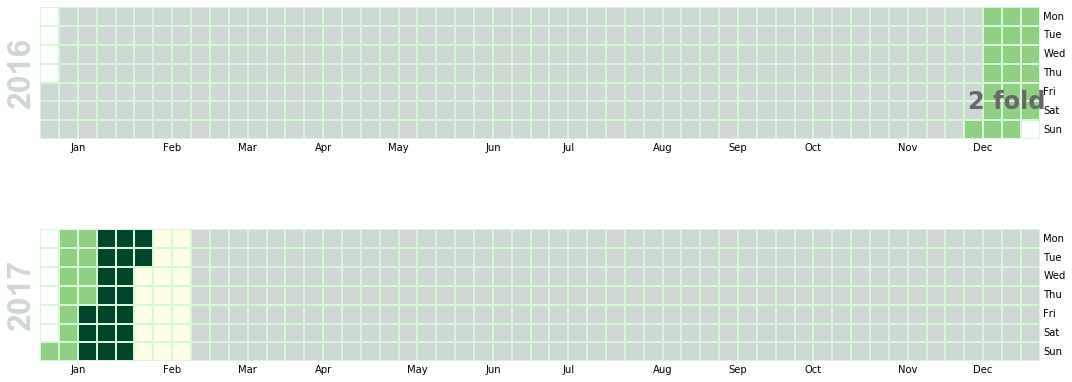

In [256]:
# Visualization of time validation

fold_number = 1
for i,j in myCViterator:
    train_data = X_train.iloc[i].listed_at.value_counts()*0 + 5
    valid_data = X_train.iloc[j].listed_at.value_counts()*0 + 10
    test_data = X_test.listed_at.value_counts()*0 + 1
    all_data = pd.concat([train_data, valid_data, test_data])
    fig, ax = calmap.calendarplot(all_data, fig_kws={"figsize":(15,7)}, fillcolor='#d0d8d6', cmap='YlGn',linecolor='#d5f8d6')
    
    text = "{} fold".format(fold_number)
    fold_number += 1
    fig.text(x=0.9, y=0.65, s=text, fontsize=24, weight='bold', color='#676868')

In [281]:
# K-fold validation vs time validation 

scores_rfc_looe = cross_val_score(
    estimator=rfc,
    X= X_train_looe, # ...
    y= y_train_looe, # ...
    scoring='roc_auc', # ...
    cv=sss, # cross-validation strategy
    n_jobs=-1
).mean()
print('RFC LeaveOneOutEncoder scoring: {}'.format(scores_rfc_looe))

scores_rfc_tv = cross_val_score(
    estimator=rfc,
    X= X_train.drop(['listed_at'],axis=1), # ...
    y= y_train, # ...
    scoring='roc_auc', # ...
    cv=myCViterator, # cross-validation strategy
    n_jobs=-1
).mean()
print('RFC LeaveOneOutEncoder scoring with time val: {}'.format(scores_rfc_tv))

RFC LeaveOneOutEncoder scoring: 0.8122262750970238
RFC LeaveOneOutEncoder scoring with time val: 0.8060593134716398


In [285]:
# Train  

sssv_est = rfc.fit(X_train_looe, y_train_looe)
tv_est = rfc.fit(X_train.drop(['listed_at'],axis=1), y_train)

In [287]:
# Predict

prediction_sss = sssv_est.predict_proba(X_test_looe)
prediction_tv = tv_est.predict_proba(X_test.drop(['listed_at'],axis=1))

In [298]:
# Compare results

print("ROC-AUC with StratifiedShuffleSplit: {}".format(roc_auc_score(y_test_looe, prediction_sss[:,1])))
print("ROC-AUC with Time Validation: {}".format(roc_auc_score(y_test, prediction_tv[:,1])))

ROC-AUC with StratifiedShuffleSplit: 0.7751341045529787
ROC-AUC with Time Validation: 0.769655327825217


## I will use LeaveOneOutEncoder for cat features
## For classification task better performance have train/test stratified split. On one hand second task is regression task. And better to use time validation. But I have very specific problem. If I shoud predict revenue of the company it's better way to choose time validation. But the task is to predict time of purchase. All product are different and have different quality. Of course every product have better chances to be purchased on days with better revenue statistics but for single product more important are features like brand name, quality etc.
# So I decided to choose stratified split for bouth classification and regression problems

# Prediction

# Random forrest with Boosting

## 1. Random forrest

In [805]:
# X_train_looe, X_train_looe, X_test_looe, y_test_looe

In [261]:
# random forrest parameters for Grid Search

rf_param_grid = {
    'max_depth': [None,5],
    'max_features':  [3, 5, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [10,12,15,20,50]
}

In [305]:
# Grid search for random forest

rf_grid_search = GridSearchCV(estimator = rfc, param_grid = rf_param_grid, 
                          cv = sss, n_jobs = -1, verbose = 2)
rf_grid_search.fit(X_train_looe, y_train_looe)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 30.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 37.0min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [None, 5], 'max_features': [3, 5, 7], 'min_samples_leaf': [1, 2, 3, 4, 5], 'min_samples_split': [2, 5], 'n_estimators': [10, 12, 15, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [306]:
rf_grid_search.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [307]:
rf_grid_search.best_score_

0.7858054693841806

In [314]:
rf_classifier = rf_grid_search.best_estimator_

In [317]:
# Random forrest cros val

rfr_classifier.fit(X_train_looe,y_train_looe)
rfr_prediction = rfr_classifier.predict_proba(X_test_looe)


scores_rfc = cross_val_score(
    estimator=rf_classifier,
    X= X_train_looe, # ...
    y= y_train_looe, # ...
    scoring='roc_auc', # ...
    cv=sss, # cross-validation strategy
    n_jobs=-1
).mean()
print('RFC cv: {}'.format(scores_rfc))
print('RFC baseline cv: {}'.format(scores_rfc_looe))

RFC cv: 0.8284981619925391
RFC baseline cv: 0.8122262750970238


In [318]:
# Results

print("RFC ROC-AUC: {}".format(roc_auc_score(y_test_looe, rfr_prediction[:,1])))
print("RFC ROC-AUC baseline: {}".format(roc_auc_score(y_test_looe, prediction_sss[:,1])))

RFC ROC-AUC: 0.804367686511425
RFC ROC-AUC baseline: 0.7751341045529787


## 2. XGBOOST

In [896]:
# Loading data into DMatrices

dtrain = xgb.DMatrix(X_train_looe , y_train_looe,  feature_names=X_train_looe.columns)
dtest = xgb.DMatrix(X_test_looe, label=y_test_looe)

In [588]:
# XGB parameters

xgb_params = {
    
    # Parameters to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric' : "auc"
}

num_rounds = 10000


In [267]:
# Building a baseline model

%%time
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=num_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.749438
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.761064
[2]	Test-auc:0.767996
[3]	Test-auc:0.772123
[4]	Test-auc:0.774537
[5]	Test-auc:0.779052
[6]	Test-auc:0.780785
[7]	Test-auc:0.782025
[8]	Test-auc:0.784474
[9]	Test-auc:0.786883
[10]	Test-auc:0.787139
[11]	Test-auc:0.787474
[12]	Test-auc:0.789423
[13]	Test-auc:0.79023
[14]	Test-auc:0.790611
[15]	Test-auc:0.791156
[16]	Test-auc:0.792477
[17]	Test-auc:0.792748
[18]	Test-auc:0.793743
[19]	Test-auc:0.794411
[20]	Test-auc:0.794554
[21]	Test-auc:0.795047
[22]	Test-auc:0.795416
[23]	Test-auc:0.795379
[24]	Test-auc:0.795848
[25]	Test-auc:0.796221
[26]	Test-auc:0.796409
[27]	Test-auc:0.796428
[28]	Test-auc:0.797143
[29]	Test-auc:0.79725
[30]	Test-auc:0.797446
[31]	Test-auc:0.797931
[32]	Test-auc:0.798444
[33]	Test-auc:0.79883
[34]	Test-auc:0.799322
[35]	Test-auc:0.799404
[36]	Test-auc:0.799604
[37]	Test-auc:0.799603
[38]	Test-auc:0.799648
[39]	Test-auc:0.800237
[40]	Test-auc:0.800543
[41]	Test-auc:

In [268]:
xgb_model.best_score

0.809511

In [353]:
print('Xboost baseline: {}'.format(xgb_model.best_score))

print('RFC cv: {}'.format(scores_rfc))
print('RFC baseline cv: {}'.format(scores_rfc_looe))

Xboost baseline: 0.809511
RFC cv: 0.8284981619925391
RFC baseline cv: 0.8122262750970238


In [270]:
xgb_prediction = xgb_model.predict(dtest)

In [358]:
print("XGB ROC-AUC: {}".format(roc_auc_score(y_test_looe, xgb_prediction)))
print("RFC ROC-AUC: {}".format(roc_auc_score(y_test_looe, rfr_prediction[:,1])))
print("RFC ROC-AUC baseline: {}".format(roc_auc_score(y_test_looe, prediction_sss[:,1])))

XGB ROC-AUC: 0.8095072788732405
RFC ROC-AUC: 0.804367686511425
RFC ROC-AUC baseline: 0.7751341045529787


In [273]:
# Use xgbfir library to find new features

xgbfir.saveXgbFI(
    xgb_model_r, 
    feature_names=X_test_looe.columns, 
    OutputXlsxFile="xgbfir_importance.xlsx"
)

In [886]:
X_train_looe['brand_name|size_label'] = X_train_looe['brand_name'] + X_train_looe['size_label']
X_test_looe['brand_name|size_label'] = X_test_looe['brand_name'] + X_test_looe['size_label']

In [275]:
dtrain_2 = xgb.DMatrix(X_train_looe , y_train_looe,  feature_names=X_train_looe.columns)
dtest_2 = xgb.DMatrix(X_test_looe, label=y_test_looe)

In [276]:
xgb_params = {
    
    # Parameters to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    
    # Other parameters
    'objective':'binary:logistic',
    'eval_metric' : "auc"
}

num_rounds = 10000


In [420]:
%%time
xgb_model = xgb.train(
    xgb_params,
    dtrain_2,
    num_boost_round=num_rounds,
    evals=[(dtest_2, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.765645
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.7712
[2]	Test-auc:0.774532
[3]	Test-auc:0.776956
[4]	Test-auc:0.778726
[5]	Test-auc:0.780796
[6]	Test-auc:0.782376
[7]	Test-auc:0.783246
[8]	Test-auc:0.785403
[9]	Test-auc:0.787056
[10]	Test-auc:0.788085
[11]	Test-auc:0.78907
[12]	Test-auc:0.789392
[13]	Test-auc:0.791345
[14]	Test-auc:0.791213
[15]	Test-auc:0.792729
[16]	Test-auc:0.792708
[17]	Test-auc:0.793056
[18]	Test-auc:0.793931
[19]	Test-auc:0.794045
[20]	Test-auc:0.794222
[21]	Test-auc:0.794623
[22]	Test-auc:0.795675
[23]	Test-auc:0.796654
[24]	Test-auc:0.79661
[25]	Test-auc:0.796711
[26]	Test-auc:0.797439
[27]	Test-auc:0.797527
[28]	Test-auc:0.797563
[29]	Test-auc:0.797875
[30]	Test-auc:0.797871
[31]	Test-auc:0.798793
[32]	Test-auc:0.799239
[33]	Test-auc:0.799124
[34]	Test-auc:0.79945
[35]	Test-auc:0.80008
[36]	Test-auc:0.800429
[37]	Test-auc:0.800524
[38]	Test-auc:0.800443
[39]	Test-auc:0.800638
[40]	Test-auc:0.800917
[41]	Test-auc:0.8

In [421]:
xgb_model.best_score

0.809855

In [422]:
print('Xboost baseline: {}'.format(xgb_model.best_score))

print('RFC cv: {}'.format(scores_rfc))
print('RFC baseline cv: {}'.format(scores_rfc_looe))

Xboost baseline: 0.809855
RFC cv: 0.8284981619925391
RFC baseline cv: 0.8122262750970238


In [423]:
xgb_prediction = xgb_model.predict(dtest_2)

In [424]:
print("XGB ROC-AUC: {}".format(roc_auc_score(y_test_looe, xgb_prediction)))
print("RFC ROC-AUC: {}".format(roc_auc_score(y_test_looe, rfr_prediction[:,1])))
print("RFC ROC-AUC baseline: {}".format(roc_auc_score(y_test_looe, prediction_sss[:,1])))

XGB ROC-AUC: 0.8097697857542053
RFC ROC-AUC: 0.804367686511425
RFC ROC-AUC baseline: 0.7751341045529787


## 2.1 Xgboost Hyperparameter tuning

In [425]:
# Xgboost baseline

cv_xgb = xgb.cv(
    xgb_params,
    dtrain,
    num_boost_round=num_rounds,
    seed=42,
    folds=sss,
    metrics={'auc'},
    early_stopping_rounds=10,
    verbose_eval=1
)


[0]	train-auc:0.785124+0.000242351	test-auc:0.782768+0.000707545
[1]	train-auc:0.797545+0.000439685	test-auc:0.794972+0.000161287
[2]	train-auc:0.803209+0.000209171	test-auc:0.80056+0.00112637
[3]	train-auc:0.806827+0.000472149	test-auc:0.803622+0.00141379
[4]	train-auc:0.810897+0.00076163	test-auc:0.807494+0.00128516
[5]	train-auc:0.813933+0.000494705	test-auc:0.810499+0.000907888
[6]	train-auc:0.816376+0.000292275	test-auc:0.812729+0.000715986
[7]	train-auc:0.818265+0.000322169	test-auc:0.814406+0.00086379
[8]	train-auc:0.820336+0.00047063	test-auc:0.816131+0.000826654
[9]	train-auc:0.821826+0.000456308	test-auc:0.817496+0.000642894
[10]	train-auc:0.82441+0.000544063	test-auc:0.819762+0.00141036
[11]	train-auc:0.825495+0.000749939	test-auc:0.820767+0.00165786
[12]	train-auc:0.826927+0.000230796	test-auc:0.821918+0.00125776
[13]	train-auc:0.827807+0.000430549	test-auc:0.822598+0.00127212
[14]	train-auc:0.829661+0.000156508	test-auc:0.82425+0.0010259
[15]	train-auc:0.830063+0.000301094

[126]	train-auc:0.867623+0.000450329	test-auc:0.840306+0.000687964
[127]	train-auc:0.867798+0.000396681	test-auc:0.840272+0.000721532
[128]	train-auc:0.868035+0.000336969	test-auc:0.840315+0.000717826
[129]	train-auc:0.868248+0.000323729	test-auc:0.840299+0.000744163
[130]	train-auc:0.86857+0.000284842	test-auc:0.840316+0.000756969
[131]	train-auc:0.868809+0.000324707	test-auc:0.840336+0.000731576
[132]	train-auc:0.868958+0.000356383	test-auc:0.840315+0.000740171
[133]	train-auc:0.869196+0.000291281	test-auc:0.840342+0.000718169
[134]	train-auc:0.869419+0.000331905	test-auc:0.840358+0.000715611
[135]	train-auc:0.869709+0.000360639	test-auc:0.840375+0.000721238
[136]	train-auc:0.869905+0.000322194	test-auc:0.840394+0.000725905
[137]	train-auc:0.870128+0.000408086	test-auc:0.840394+0.000708359
[138]	train-auc:0.870401+0.000380251	test-auc:0.840374+0.00072424
[139]	train-auc:0.870537+0.000521478	test-auc:0.840394+0.000726298
[140]	train-auc:0.870776+0.000484516	test-auc:0.840429+0.0007421

In [277]:
# max_depth, min_child_weight search parameters

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,10)
    for min_child_weight in range(1,5)
]

In [436]:
cv_xgb['test-auc-mean'].max()

0.840608

In [439]:
%%time

# max_depth, min_child_weight grid search and validation

max_auc = float(0)
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    xgb_params['max_depth'] = max_depth
    xgb_params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        xgb_params,
        dtrain,
        num_boost_round=num_rounds,
        seed=42,
        folds=sss,
        metrics={'auc'},
        early_stopping_rounds=10
    )

    # Update best AUC
    mean_auc = cv_results['test-auc-mean'].max()
    num_boost_round = cv_results["test-auc-mean"].argmax()
    print("\nAUC {} for {} rounds".format(mean_auc, num_boost_round))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

CV with max_depth=5, min_child_weight=1
\AUC 0.8415306666666665 for 305 rounds
CV with max_depth=5, min_child_weight=2
\AUC 0.8410983333333334 for 221 rounds
CV with max_depth=5, min_child_weight=3
\AUC 0.8416456666666666 for 292 rounds
CV with max_depth=5, min_child_weight=4
\AUC 0.8415726666666666 for 237 rounds
CV with max_depth=6, min_child_weight=1
\AUC 0.840608 for 157 rounds
CV with max_depth=6, min_child_weight=2
\AUC 0.840232 for 172 rounds
CV with max_depth=6, min_child_weight=3
\AUC 0.840376 for 148 rounds
CV with max_depth=6, min_child_weight=4
\AUC 0.8401446666666667 for 136 rounds
CV with max_depth=7, min_child_weight=1
\AUC 0.840208 for 110 rounds
CV with max_depth=7, min_child_weight=2
\AUC 0.8403036666666667 for 137 rounds
CV with max_depth=7, min_child_weight=3
\AUC 0.840157 for 125 rounds
CV with max_depth=7, min_child_weight=4
\AUC 0.8399956666666667 for 137 rounds
CV with max_depth=8, min_child_weight=1
\AUC 0.8393226666666666 for 94 rounds
CV with max_depth=8, min

In [589]:
# Save new params

xgb_params['max_depth'] = 5
xgb_params['min_child_weight'] = 3

In [590]:
xgb_params

{'max_depth': 5,
 'min_child_weight': 3,
 'eta': 0.3,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [280]:
# subsample and colsample grid search

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
# Parameters subsample and colsample_bytree

%%time
max_auc = float(0)
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    xgb_params['subsample'] = subsample
    xgb_params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        xgb_params,
        dtrain,
        num_boost_round=num_rounds,
        seed=42,
        folds=sss,
        metrics={'auc'},
        early_stopping_rounds=10
    )

    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    num_boost_round = cv_results["test-auc-mean"].argmax()
    
    print("\tAUC {} for {} rounds".format(mean_auc, num_boost_round))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample)

print("Best params: {}, {}, colsample: {}".format(best_params[0], best_params[1], max_auc))

CV with subsample=1.0, colsample=1.0
	AUC 0.8416456666666666 for 292 rounds
CV with subsample=1.0, colsample=0.9
	AUC 0.8415523333333333 for 280 rounds
CV with subsample=1.0, colsample=0.8
	AUC 0.841615 for 321 rounds
CV with subsample=1.0, colsample=0.7
	AUC 0.8415913333333335 for 304 rounds
CV with subsample=0.9, colsample=1.0
	AUC 0.8410606666666666 for 266 rounds
CV with subsample=0.9, colsample=0.9
	AUC 0.841228 for 267 rounds
CV with subsample=0.9, colsample=0.8
	AUC 0.841132 for 268 rounds
CV with subsample=0.9, colsample=0.7
	AUC 0.8410246666666668 for 262 rounds
CV with subsample=0.8, colsample=1.0
	AUC 0.8404823333333334 for 248 rounds
CV with subsample=0.8, colsample=0.9
	AUC 0.8401666666666667 for 229 rounds
CV with subsample=0.8, colsample=0.8


In [ ]:
# Parameter ETA

max_auc = float(0)
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # Update our parameters
    xgb_params['eta'] = eta

    # Run and time CV
    %time cv_results = xgb.cv(
            xgb_params,
            dtrain,
            num_boost_round=num_rounds,
            seed=42,
            folds=sss,
            metrics=['auc'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    num_boost_round = cv_results["test-auc-mean"].argmax()
    print("\tAUC {} for {} rounds\n".format(mean_mae, num_boost_round))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = eta

print("Best params: {}, AUC: {}".format(best_params, max_auc))

In [467]:
# I'v lost results of eta parameter grid search/ but it was .1,
# research will take  lot of time

In [591]:
xgb_params['eta'] = .1

In [592]:
# Here is how our final dictionary of parameters looks like

xgb_params

{'max_depth': 5,
 'min_child_weight': 3,
 'eta': 0.1,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

In [755]:
# Testing after grid search

%%time
xgb_model_r = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=num_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.757442
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.759863
[2]	Test-auc:0.762288
[3]	Test-auc:0.765824
[4]	Test-auc:0.768061
[5]	Test-auc:0.768493
[6]	Test-auc:0.769064
[7]	Test-auc:0.770012
[8]	Test-auc:0.770585
[9]	Test-auc:0.771792
[10]	Test-auc:0.772462
[11]	Test-auc:0.773579
[12]	Test-auc:0.774426
[13]	Test-auc:0.775064
[14]	Test-auc:0.775584
[15]	Test-auc:0.776184
[16]	Test-auc:0.777393
[17]	Test-auc:0.77762
[18]	Test-auc:0.777912
[19]	Test-auc:0.7786
[20]	Test-auc:0.779463
[21]	Test-auc:0.779897
[22]	Test-auc:0.780124
[23]	Test-auc:0.780507
[24]	Test-auc:0.780794
[25]	Test-auc:0.781173
[26]	Test-auc:0.781836
[27]	Test-auc:0.782352
[28]	Test-auc:0.782995
[29]	Test-auc:0.78357
[30]	Test-auc:0.783971
[31]	Test-auc:0.784298
[32]	Test-auc:0.78465
[33]	Test-auc:0.785315
[34]	Test-auc:0.785509
[35]	Test-auc:0.785708
[36]	Test-auc:0.786761
[37]	Test-auc:0.787219
[38]	Test-auc:0.787348
[39]	Test-auc:0.787567
[40]	Test-auc:0.787971
[41]	Test-auc:0.

[346]	Test-auc:0.806868
[347]	Test-auc:0.806873
[348]	Test-auc:0.806903
[349]	Test-auc:0.806904
[350]	Test-auc:0.806919
[351]	Test-auc:0.806952
[352]	Test-auc:0.806966
[353]	Test-auc:0.806967
[354]	Test-auc:0.806989
[355]	Test-auc:0.807023
[356]	Test-auc:0.807048
[357]	Test-auc:0.807071
[358]	Test-auc:0.8071
[359]	Test-auc:0.80712
[360]	Test-auc:0.807124
[361]	Test-auc:0.807155
[362]	Test-auc:0.80715
[363]	Test-auc:0.807197
[364]	Test-auc:0.807222
[365]	Test-auc:0.807258
[366]	Test-auc:0.807273
[367]	Test-auc:0.807314
[368]	Test-auc:0.807314
[369]	Test-auc:0.807322
[370]	Test-auc:0.807328
[371]	Test-auc:0.807331
[372]	Test-auc:0.807358
[373]	Test-auc:0.807353
[374]	Test-auc:0.80736
[375]	Test-auc:0.807364
[376]	Test-auc:0.80737
[377]	Test-auc:0.8074
[378]	Test-auc:0.807399
[379]	Test-auc:0.807409
[380]	Test-auc:0.807423
[381]	Test-auc:0.807428
[382]	Test-auc:0.807427
[383]	Test-auc:0.807452
[384]	Test-auc:0.807465
[385]	Test-auc:0.80751
[386]	Test-auc:0.807555
[387]	Test-auc:0.807619
[

In [756]:
xgb_model_r.best_score

0.810396

In [351]:
xgb_model.best_score

0.809511

In [757]:
print('Xboost result: {}'.format(xgb_model_r.best_score))

Xboost result: 0.810396


In [593]:
# experiment 

xgb_params['subsample'] = .8
xgb_params['colsample_bytree'] = .8

In [808]:
xgb_params

{'max_depth': 5,
 'min_child_weight': 3,
 'eta': 0.1,
 'subsample': 0.8,
 'colsample_bytree': 0.8,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

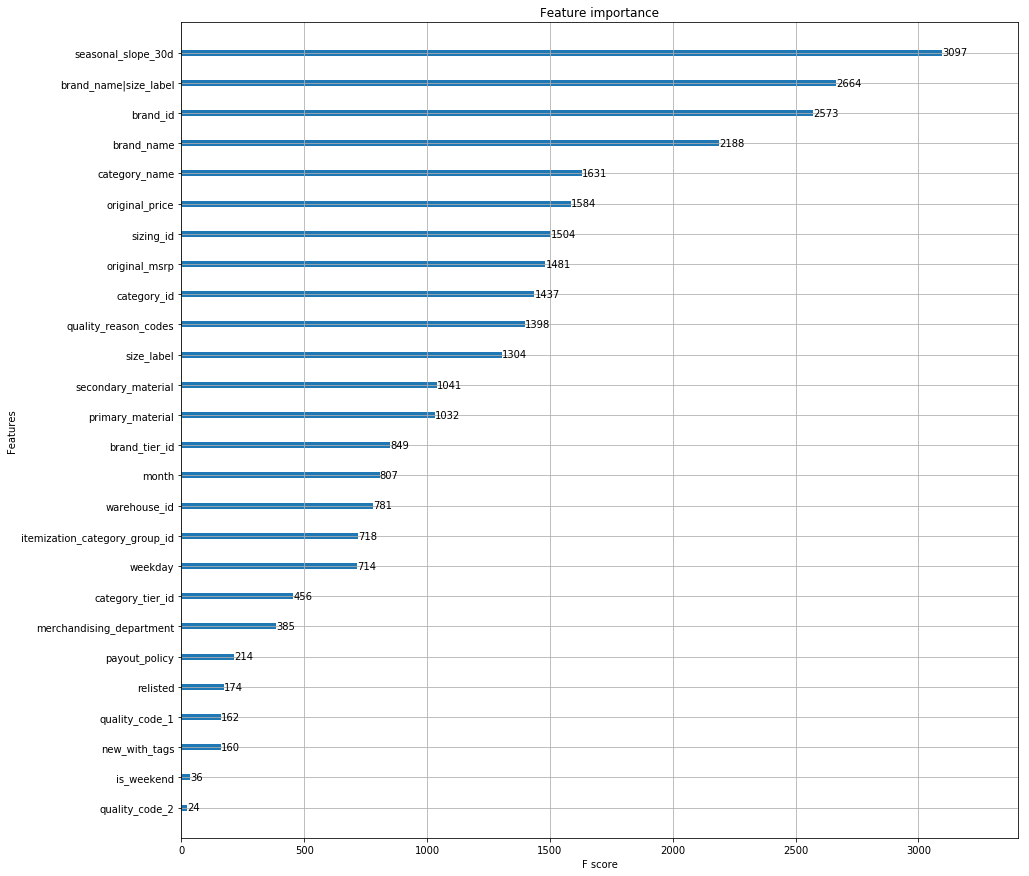

In [899]:
plt.rcParams['figure.figsize']=15,15
xgb.plot_importance(xgb_model_r)

In [897]:
# Final model

%%time
xgb_model_r = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=num_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-auc:0.757952
Will train until Test-auc hasn't improved in 10 rounds.
[1]	Test-auc:0.76193
[2]	Test-auc:0.76374
[3]	Test-auc:0.771828
[4]	Test-auc:0.772501
[5]	Test-auc:0.77267
[6]	Test-auc:0.772959
[7]	Test-auc:0.772717
[8]	Test-auc:0.773719
[9]	Test-auc:0.774163
[10]	Test-auc:0.774969
[11]	Test-auc:0.775613
[12]	Test-auc:0.775702
[13]	Test-auc:0.776646
[14]	Test-auc:0.776944
[15]	Test-auc:0.777423
[16]	Test-auc:0.777844
[17]	Test-auc:0.778153
[18]	Test-auc:0.77888
[19]	Test-auc:0.779649
[20]	Test-auc:0.779735
[21]	Test-auc:0.77985
[22]	Test-auc:0.780326
[23]	Test-auc:0.780928
[24]	Test-auc:0.781389
[25]	Test-auc:0.781901
[26]	Test-auc:0.782018
[27]	Test-auc:0.782465
[28]	Test-auc:0.783166
[29]	Test-auc:0.783592
[30]	Test-auc:0.783969
[31]	Test-auc:0.784413
[32]	Test-auc:0.784799
[33]	Test-auc:0.785079
[34]	Test-auc:0.785653
[35]	Test-auc:0.785865
[36]	Test-auc:0.786631
[37]	Test-auc:0.786626
[38]	Test-auc:0.787147
[39]	Test-auc:0.787312
[40]	Test-auc:0.787694
[41]	Test-auc:0.

[346]	Test-auc:0.807178
[347]	Test-auc:0.807196
[348]	Test-auc:0.807234
[349]	Test-auc:0.807257
[350]	Test-auc:0.807247
[351]	Test-auc:0.807279
[352]	Test-auc:0.807285
[353]	Test-auc:0.807305
[354]	Test-auc:0.807304
[355]	Test-auc:0.807341
[356]	Test-auc:0.807343
[357]	Test-auc:0.807354
[358]	Test-auc:0.807376
[359]	Test-auc:0.80739
[360]	Test-auc:0.807417
[361]	Test-auc:0.807457
[362]	Test-auc:0.807463
[363]	Test-auc:0.80747
[364]	Test-auc:0.807464
[365]	Test-auc:0.807499
[366]	Test-auc:0.807506
[367]	Test-auc:0.8075
[368]	Test-auc:0.807514
[369]	Test-auc:0.807515
[370]	Test-auc:0.807522
[371]	Test-auc:0.80755
[372]	Test-auc:0.807538
[373]	Test-auc:0.807528
[374]	Test-auc:0.807534
[375]	Test-auc:0.807552
[376]	Test-auc:0.807572
[377]	Test-auc:0.807565
[378]	Test-auc:0.807573
[379]	Test-auc:0.80759
[380]	Test-auc:0.807629
[381]	Test-auc:0.807648
[382]	Test-auc:0.807672
[383]	Test-auc:0.807687
[384]	Test-auc:0.807687
[385]	Test-auc:0.8077
[386]	Test-auc:0.807726
[387]	Test-auc:0.807723


[690]	Test-auc:0.810704
[691]	Test-auc:0.8107
[692]	Test-auc:0.810695
[693]	Test-auc:0.810697
[694]	Test-auc:0.810705
[695]	Test-auc:0.81072
[696]	Test-auc:0.810708
[697]	Test-auc:0.810708
[698]	Test-auc:0.810709
[699]	Test-auc:0.810708
[700]	Test-auc:0.810714
[701]	Test-auc:0.810722
[702]	Test-auc:0.810729
[703]	Test-auc:0.810749
[704]	Test-auc:0.81075
[705]	Test-auc:0.810743
[706]	Test-auc:0.810746
[707]	Test-auc:0.810742
[708]	Test-auc:0.810748
[709]	Test-auc:0.810746
[710]	Test-auc:0.810756
[711]	Test-auc:0.810752
[712]	Test-auc:0.810758
[713]	Test-auc:0.810758
[714]	Test-auc:0.810761
[715]	Test-auc:0.810781
[716]	Test-auc:0.810777
[717]	Test-auc:0.810771
[718]	Test-auc:0.810777
[719]	Test-auc:0.810776
[720]	Test-auc:0.810765
[721]	Test-auc:0.810787
[722]	Test-auc:0.810793
[723]	Test-auc:0.810801
[724]	Test-auc:0.810824
[725]	Test-auc:0.810826
[726]	Test-auc:0.810833
[727]	Test-auc:0.810849
[728]	Test-auc:0.810869
[729]	Test-auc:0.81087
[730]	Test-auc:0.810874
[731]	Test-auc:0.8108

[1032]	Test-auc:0.812178
[1033]	Test-auc:0.812177
[1034]	Test-auc:0.81218
[1035]	Test-auc:0.812184
[1036]	Test-auc:0.812196
[1037]	Test-auc:0.812198
[1038]	Test-auc:0.812197
[1039]	Test-auc:0.812202
[1040]	Test-auc:0.812199
[1041]	Test-auc:0.812197
[1042]	Test-auc:0.812201
[1043]	Test-auc:0.812202
[1044]	Test-auc:0.812192
[1045]	Test-auc:0.812197
[1046]	Test-auc:0.812203
[1047]	Test-auc:0.812197
[1048]	Test-auc:0.812196
[1049]	Test-auc:0.812192
[1050]	Test-auc:0.812197
[1051]	Test-auc:0.812199
[1052]	Test-auc:0.812202
[1053]	Test-auc:0.812204
[1054]	Test-auc:0.812202
[1055]	Test-auc:0.812195
[1056]	Test-auc:0.812198
[1057]	Test-auc:0.812204
[1058]	Test-auc:0.812204
[1059]	Test-auc:0.812206
[1060]	Test-auc:0.812198
[1061]	Test-auc:0.812206
[1062]	Test-auc:0.81222
[1063]	Test-auc:0.812211
[1064]	Test-auc:0.812215
[1065]	Test-auc:0.812222
[1066]	Test-auc:0.812236
[1067]	Test-auc:0.812226
[1068]	Test-auc:0.812224
[1069]	Test-auc:0.812217
[1070]	Test-auc:0.812216
[1071]	Test-auc:0.812224
[1

In [900]:
print('Xboost result: {}'.format(xgb_model_r.best_score))

Xboost result: 0.812312


In [353]:
print('Xboost baseline: {}'.format(xgb_model.best_score))

print('RFC cv: {}'.format(scores_rfc))
print('RFC baseline cv: {}'.format(scores_rfc_looe))

Xboost baseline: 0.809511
RFC cv: 0.8284981619925391
RFC baseline cv: 0.8122262750970238


In [901]:
# Prediction 

xgb_predict = xgb_model_r.predict(dtest)

In [833]:
print("XGB final prediction ROC-AUC: {}".format(roc_auc_score(y_test_looe, xgb_predict)))

XGB final prediction ROC-AUC: 0.812299860762517


In [358]:
print("XGB ROC-AUC: {}".format(roc_auc_score(y_test_looe, xgb_prediction)))
print("RFC ROC-AUC: {}".format(roc_auc_score(y_test_looe, rfr_prediction[:,1])))
print("RFC ROC-AUC baseline: {}".format(roc_auc_score(y_test_looe, prediction_sss[:,1])))

XGB ROC-AUC: 0.8095072788732405
RFC ROC-AUC: 0.804367686511425
RFC ROC-AUC baseline: 0.7751341045529787


In [903]:
xgb_predict_df = pd.DataFrame(xgb_predict,index=y_test_looe.index,columns=["xgb_prediction"])

In [904]:
xgb_predict_df.isna().any()

xgb_prediction    False
dtype: bool

In [905]:
xgb_predict_df['prediction'] = xgb_predict_df["xgb_prediction"].apply(lambda x: 1 if x>0.50 else 0)

In [906]:
xgb_predict_df = pd.concat([xgb_predict_df,y_test_looe],axis=1)

In [907]:
metrics.accuracy_score(y_pred=xgb_predict_df.prediction, y_true=xgb_predict_df.is_purchased) #0.5

0.782656056587091

# Roc Curve

In [611]:
fpr, tpr,_=metrics.roc_curve(y_test_looe, xgb_predict)

Text(0.5,1,'ROC curve')

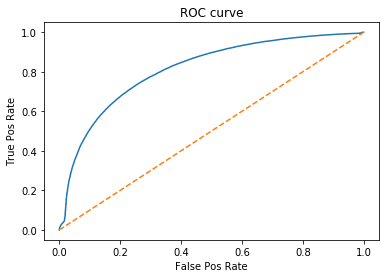

In [612]:
pylab.plot(fpr,tpr, label='rfc')
pylab.plot([0,1],[0,1],'--', label='random')
pylab.xlim([-0.05,1.05])
pylab.ylim([-0.05,1.05])
pylab.xlabel("False Pos Rate")
pylab.ylabel("True Pos Rate")
pylab.title("ROC curve")

# Regression task

In [637]:
#X_train_reg = data_df_looe.loc[X_train_leo.index]
#y_train_reg = data_df_looe.loc[X_train_leo.index].is_purchased
#X_test_reg = data_df_looe.loc[X_test_leo.index]
#y_test_reg = data_df_looe.loc[X_test_leo.index].is_purchased

In [638]:
# Convert to datetime date columns

data_df_looe.purchased_at = data_df_looe.purchased_at.apply(lambda x: pd.to_datetime(x))
data_df_looe.listed_at = data_df_looe.listed_at.apply(lambda x: pd.to_datetime(x))


In [639]:
data_df_looe["days_before_purchase"] = data_df_looe.purchased_at.apply(lambda x: x.replace(hour = 0,minute = 0, second = 0)) - data_df_looe.listed_at.apply(lambda x: x.replace(hour = 0,minute = 0, second = 0))

In [640]:
# Create train/test sets

X_train_reg = data_df_looe.loc[X_train_leo.index]
y_train_reg = data_df_looe.loc[X_train_leo.index].loc[:,['listed_at', 'purchased_at', 'is_purchased','days_before_purchase']]
X_test_reg = data_df_looe.loc[X_test_leo.index]
y_test_reg = data_df_looe.loc[X_test_leo.index].loc[:,['listed_at', 'purchased_at', 'is_purchased', 'days_before_purchase']]

In [619]:
data_df_looe.loc[X_train_leo.index].loc[:,['listed_at', 'purchased_at', 'is_purchased', 'days_before_purchase']].head()

,listed_at,purchased_at,is_purchased,days_before_purchase
223281,2017-01-05 02:01:25,2017-02-03 10:24:50,1,29 days
420103,2016-12-01 20:01:34,2016-12-14 11:44:42,1,13 days
132504,2017-01-24 15:01:06,2017-01-31 07:38:37,1,7 days
148099,2017-01-20 10:01:43,2017-01-27 06:02:52,1,7 days
56324,2017-02-07 11:00:26,2017-02-11 13:06:12,1,4 days


# Now I have a problem whot to train and how to test...

## 1. Drop all not purchased objects from train and test. Make regression model on that data. Ignore  previous classification

## 2. Drop all not purchased objects from train. Build regression model to predict day when product would purchased. Ignore all  folse positive predictions from classification task. But I wouldn't have a final score then.

## 3. Drop all not purchased objects from train and test. then drop all false positive objects from test and use regression model on that data.

# I choose # 2)

In [641]:
# Drop all NaNs from Train ds

X_train_reg.dropna(inplace=True)
y_train_reg.dropna(inplace=True)


In [642]:
# Convert days needed to be purchased into int

X_train_reg.days_before_purchase = X_train_reg.days_before_purchase.dt.days  
y_train_reg.days_before_purchase = y_train_reg.days_before_purchase.dt.days

X_test_reg.days_before_purchase = X_test_reg.days_before_purchase.dt.days  
y_test_reg.days_before_purchase = y_test_reg.days_before_purchase.dt.days

In [644]:
# Left pruducts that was predicted as purchased

y_test_xgb_pred_df = pd.concat([y_test_reg, xgb_predict_df.prediction],axis=1)
y_test_reg_pred = y_test_xgb_pred_df[y_test_xgb_pred_df.prediction==1]
X_test_reg_pred = X_test_reg.loc[y_test_reg_pred.index]

In [648]:
# Create Random forest regressor

rfr = RandomForestRegressor(random_state=42)

In [346]:
# y_train_reg.iloc[:,-1]

In [649]:
# Create Test data for regression experiments

X = X_train_reg.drop(['listed_at', 'purchased_at','is_purchased', 'days_before_purchase'],axis=1)
y= y_train_reg.iloc[:,3:4]

In [658]:
%%time

scores_rfr = cross_val_score(
    estimator=rfr,
    X= X,
    y= y,
    scoring='mean_absolute_error', # ...
    cv=sss, # cross-validation strategy
    n_jobs=-1
).mean()*-1
print('RF regressor MAE score: {}'.format(scores_rfr))

RF regressor MAE score: 11.533914670754648
Wall time: 18.1 s


In [665]:
# Grid search params for regression estimator

rfr_param_grid = {
    'max_depth': [None],
    'max_features':  [3, 5, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5],
    'n_estimators': [10,15,20,50]
}

In [ ]:
# Grid search

%%time
grid_search = GridSearchCV(estimator = rfr, param_grid = rfr_param_grid, 
                          cv = sss, n_jobs = -1, verbose = 2)
grid_search.fit(X, y)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.0min


In [666]:
# Finalparameters

grid_search.best_params_

{'max_depth': None,
 'max_features': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [667]:
rfr_grid = grid_search.best_estimator_

In [668]:
grid_search.best_score_

0.19037236876850933

In [670]:
# Train Random forrest regressor

rfr_grid.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [671]:
# Predict days needed to be purchased

rer_prediction = rfr_grid.predict(X_test_reg_pred.drop(['listed_at', 'purchased_at','is_purchased', 'days_before_purchase'],axis=1))

In [673]:
# Table of all predictions

rer_prediction = pd.DataFrame(rer_prediction,index=y_test_reg_pred.index,columns=["regression_pred"])
final_prediction_df = pd.merge(y_test_xgb_pred_df, rer_prediction, how='outer', left_index=True, right_index=True)
final_prediction_df.head()

In [676]:
#

final_prediction_df.purchased_at = final_prediction_df.purchased_at.fillna("Wasn't purchased")
final_prediction_df.days_before_purchase = final_prediction_df.days_before_purchase.fillna("Wasn't purchased")
final_prediction_df.regression_pred = final_prediction_df.regression_pred.fillna("Predict as not purchased")

In [677]:
final_prediction_df.head()

,listed_at,purchased_at,is_purchased,days_before_purchase,prediction,regression_pred
3,2017-02-19 14:01:54,Wasn't purchased,0,Wasn't purchased,0,Predict as not purchased
6,2017-02-19 14:01:51,Wasn't purchased,0,Wasn't purchased,0,Predict as not purchased
10,2017-02-19 14:01:49,2017-02-19 16:19:07,1,0,1,1.8158
16,2017-02-19 14:01:46,Wasn't purchased,0,Wasn't purchased,1,2.93895
17,2017-02-19 14:01:45,Wasn't purchased,0,Wasn't purchased,0,Predict as not purchased


# Summary 

In [ ]:
# 1. Load data fom csv (Some objects has different length of row) 
# 2. Preprocessing data(Fill and delete rows and objects with NaN's, convert some features with type object to int, catigorical features to lower case)
# 3. Feature engineering (Backward difference for ordinal data Leave one out for categorical. Create new feature with the help og xgbfir)
# 4. To predict how long it will take for each item to be purchased I first predict if product would be purchased. Then I build regression model and predict how long it will take for each item to be purchased 
# 5. I try time and stratified validations and choose stratified. All product are different and have different quality. Of course every product have better chances to be purchased on days with better revenue statistics but for single product more important are features like brand name, quality etc.


# Result analysis

In [833]:
print("XGB final prediction ROC-AUC: {}".format(roc_auc_score(y_test_looe, xgb_predict)))

XGB final prediction ROC-AUC: 0.812299860762517


In [698]:
print(classification_report(y_test_looe, xgb_predict_df.prediction))

             precision    recall  f1-score   support

          0       0.66      0.50      0.57     40695
          1       0.82      0.90      0.85    100680

avg / total       0.77      0.78      0.77    141375



In [703]:
print("RMSE for object classified as 1:{}".format(np.sqrt(mean_squared_error(y_true=y_test_xgb_pred_df.loc[true_positive_df.index].days_before_purchase, y_pred=true_positive_df.regression_pred))))

RMSE for object classified as 1:14.847688009843447


# Most predictive features for classification

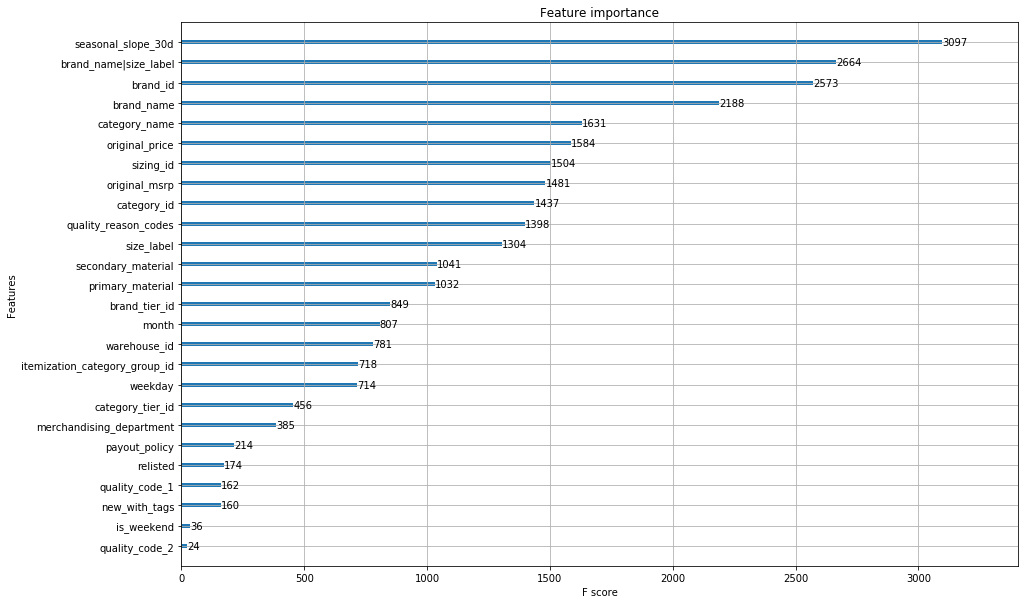

In [910]:
plt.rcParams['figure.figsize']=15,10
xgb.plot_importance(xgb_model_r)

## I created feature 'brand|size_label'

In [919]:
X_train_looe.columns

Index(['brand_id', 'brand_name', 'brand_tier_id', 'category_id',
       'category_name', 'category_tier_id', 'itemization_category_group_id',
       'sizing_id', 'size_label', 'new_with_tags', 'quality_reason_codes',
       'merchandising_department', 'primary_material', 'secondary_material',
       'original_msrp', 'original_price', 'payout_policy',
       'seasonal_slope_30d', 'relisted', 'warehouse_id', 'quality_code_0',
       'quality_code_1', 'quality_code_2', 'weekday', 'is_weekend', 'month',
       'brand_name|size_label'],
      dtype='object')

In [918]:
indices

array([25, 17,  1,  0, 14, 15,  8,  4,  7,  3, 23, 12, 10, 19, 13,  2,  6,
        5, 11, 18, 21,  9, 16, 24, 22, 20], dtype=int64)

Feature ranking:
1. month 0.259072 
2. seasonal_slope_30d 0.099722 
3. brand_name 0.070592 
4. brand_id 0.064488 
5. original_msrp 0.050199 
6. original_price 0.049376 
7. size_label 0.046401 
8. category_name 0.041166 
9. sizing_id 0.037260 
10. category_id 0.034412 


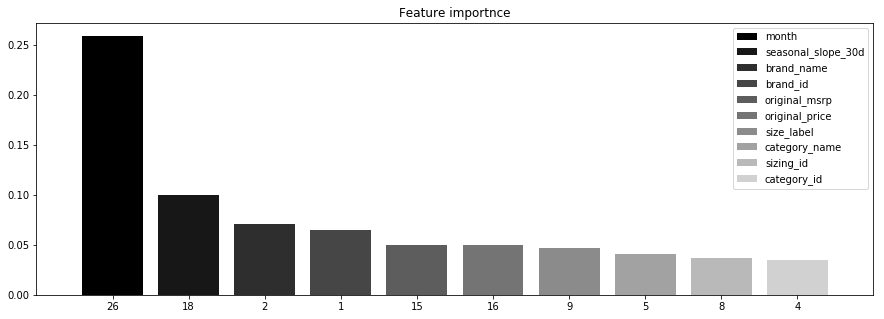

In [924]:
features = {"f1":u"brand_id",
"f2":u"brand_name",
"f3":u"brand_tier_id",
"f4":u"category_id",
"f5":u"category_name",
"f6":u"category_tier_id",
"f7":u"itemization_category_group_id",
"f8":u"sizing_id",
"f9":u"size_label",
"f10":u"new_with_tags",
"f11":u"quality_reason_codes",
"f12":u"merchandising_department",
"f13":u"primary_material",
"f14":u"secondary_material",
"f15":u"original_msrp",
"f16":u"original_price",
"f17":u"payout_policy",
"f18":u"seasonal_slope_30d",
"f19":u"relisted",
"f20":u"warehouse_id",
"f21":u"quality_code_0",
"f22":u"quality_code_1",
"f23":u"quality_code_2",
"f24":u"weekday",
"f25":u"is_weekend",
"f26":u"month",
"f27":u"brand_name|size_label"}



importances = rfr_grid.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")
  
for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Feature importnce")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

In [704]:
# df's for future analesis

true_positive_df = final_prediction_df[(final_prediction_df.prediction==1)&(final_prediction_df.is_purchased==1)]
false_positive_df = final_prediction_df[(final_prediction_df.prediction==1)&(final_prediction_df.is_purchased==0)]

true_negative_df = final_prediction_df[(final_prediction_df.prediction==0)&(final_prediction_df.is_purchased==0)]
false_negative__df = final_prediction_df[(final_prediction_df.prediction==0)&(final_prediction_df.is_purchased==1)]

In [705]:
print("\tThe size of test dataset: {} objects\n".format(final_prediction_df.shape[0]))

print("\tNumber of true positive classified objects: {} objects\n".format(true_positive_df.shape[0]))

print("\tNumber of false positive classified objects: {} objects\n".format(false_positive_df.shape[0]))

print("\t% of pos accuracy: {}\n".format(true_positive_df.shape[0]/ (true_positive_df.shape[0]+false_negative__df.shape[0])))

print('\tOverall purchased objects in test dataset: {}\n'.format(true_positive_df.shape[0]+false_negative__df.shape[0]))

print("\tNumber of true negative classified objects: {} objects\n".format(true_negative_df.shape[0]))

print("\tNumber of false negative classified objects: {} objects\n".format(false_negative__df.shape[0]))

print("\t% of neg accuracy: {}\n".format(true_negative_df.shape[0] / (true_negative_df.shape[0]+false_positive_df.shape[0])))

print('\tOverall not purchased objects in test dataset: {}\n'.format(true_negative_df.shape[0]+false_positive_df.shape[0]))

print("\tXGB final prediction ROC-AUC: {}\n".format(roc_auc_score(y_test_looe, xgb_predict)))

print("\tXGB final accuracy: {}\n".format(metrics.accuracy_score(y_pred=xgb_predict_df.prediction, y_true=xgb_predict_df.is_purchased) ))

	The size of test dataset: 141375 objects

	Number of true positive classified objects: 90334 objects

	Number of false positive classified objects: 20381 objects

	% of pos accuracy: 0.8972387763210171

	Overall purchased objects in test dataset: 100680

	Number of true negative classified objects: 20314 objects

	Number of false negative classified objects: 10346 objects

	% of neg accuracy: 0.49917680304705736

	Overall not purchased objects in test dataset: 40695

	XGB final prediction ROC-AUC: 0.812299860762517

	XGB final accuracy: 0.782656056587091

